In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

%pip install rasterio
%pip install fiona
%pip install geopandas
%pip install earthpy
%pip install Pillow
%pip install gdal
%pip install tifffile
%pip install imagecodecs

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 31.9 MB/s eta 0:00:00


In [2]:
import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
from rasterio.coords import disjoint_bounds
from rasterio.windows import from_bounds
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio import mask
from rasterio.features import geometry_mask
from rasterio import features
from rasterio.enums import MergeAlg

from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj

import geopandas as gpd

from osgeo import gdal
import matplotlib.pyplot as mplot
import numpy as np
from numpy import int16

from PIL import Image

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import fiona
import geopandas as gpd
from shapely.geometry import box

import os
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep

import math

### Convert shapefiles into binary rasters

In [3]:
orthos = ['deputten_20m', 'deputten_ortho_noord', 'steenplaat_vlucht2', 'texel_PHZ_vlucht2_deel1', 'waterdunen_vlucht1']

In [ ]:
# Reproject so that raster and shapes have same CRS and save
# Convert shapefile to binary mask raster and save

for ortho in orthos:

    # Shapefile path
    shp_path = "gdrive/My Drive/Stage/Data/Input/Train/Shapes/" + ortho + ".shp"

    # Load the shapefile
    gdf = gpd.read_file(shp_path)

    # Raster path
    raster_path = "gdrive/My Drive/Stage/Data/Input/Train/Rasters/" + ortho + ".tif"

    # Reprojected path raster
    repr_raster_path = "gdrive/My Drive/Stage/Data/Input/Train/Rasters/Reprojected/" + ortho + ".tif"

    # Shaperaster path (output)
    shape_raster_path = "gdrive/My Drive/Stage/Data/Input/Train/ShapeRasters/" + ortho + ".tif"

    with rasterio.open(raster_path) as src:

        # Get the CRS of the shapefile
        target_crs = gdf.crs

        # Reproject the raster to match the CRS of the shapefile
        transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(repr_raster_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

        dst = rasterio.open(repr_raster_path)

        # Generate a mask based on the polygons
        mask = geometry_mask(gdf.geometry, out_shape=dst.shape, transform=dst.transform, invert=True)

        # Create a new array filled with zeros
        new_array = np.zeros_like(dst.read(1))

        # Set values to 1 where the polygons are present
        new_array[mask] = 1

        # Save the new raster
        profile = dst.profile
        profile.update(count=1, dtype='uint8', nodata=None)  # Remove nodata value
        with rasterio.open(shape_raster_path, 'w', **profile) as newr:
            newr.write(new_array.astype('uint8'), 1)


### Tile

In [4]:
# Convert rasters to images
# Tile images

# Save tiles in lists
raster_tiles = []
mask_tiles = []

for ortho in orthos:

    # Reprojected raster path
    repr_raster_path = "gdrive/My Drive/Stage/Data/Input/Train/Rasters/Reprojected/" + ortho + ".tif"

    # Shaperaster (binary raster) path
    shape_raster_path = "gdrive/My Drive/Stage/Data/Input/Train/ShapeRasters/" + ortho + ".tif"

    # Load in GDAL
    raster_data_set = gdal.Open(repr_raster_path)
    mask_data_set = gdal.Open(shape_raster_path)

    # Convert to array image
    raster_band_1 = raster_data_set.GetRasterBand(1) # red channel
    raster_band_2 = raster_data_set.GetRasterBand(2) # green channel
    raster_band_3 = raster_data_set.GetRasterBand(3) # blue channel
    mask_band_1 = mask_data_set.GetRasterBand(1) # first/only channel

    # Convert to array image
    raster_b1 = raster_band_1.ReadAsArray()
    raster_b2 = raster_band_2.ReadAsArray()
    raster_b3 = raster_band_3.ReadAsArray()
    mask_b1 = mask_band_1.ReadAsArray()

    # Stack to image
    raster_img = np.dstack((raster_b1, raster_b2, raster_b3))
    mask_img = np.dstack((mask_b1))
    mask_img = mask_img[0].T # Transpose because axis was inverted (why?)

    # WxH tile pixel size
    W = 250 # was 100
    H = 250

    # Split in to M and N tiles
    ortho_raster_tiles = [raster_img[x:x+W,y:y+H] for x in range(0,raster_img.shape[0],W) for y in range(0,raster_img.shape[1],H)]
    ortho_mask_tiles = [mask_img[x:x+W,y:y+H] for x in range(0,mask_img.shape[0],W) for y in range(0,mask_img.shape[1],H)]

    # Save into larger list
    raster_tiles = raster_tiles + ortho_raster_tiles
    mask_tiles = mask_tiles + ortho_mask_tiles

    print(ortho, "split into", len(ortho_raster_tiles), "tiles", "\n")

print("Total tiles:", len(raster_tiles))

deputten_20m split into 126 tiles 

deputten_ortho_noord split into 264 tiles 

steenplaat_vlucht2 split into 364 tiles 

texel_PHZ_vlucht2_deel1 split into 726 tiles 

waterdunen_vlucht1 split into 779 tiles 

Total tiles: 2259


#### Extra: filter/remove tiles with no birds and/or NoData

In [5]:
import random

# Remove tiles with NoData (black borders)
for i in range(len(raster_tiles)):

  # Value 0 = black (but sometimes < 0  or > 256)
  if (raster_tiles[i] == 0).all() or (raster_tiles[i] < 0).all() or (raster_tiles[i] > 256).all(): # all or any?
    raster_tiles[i] = None
    mask_tiles[i] = None

# Filter
raster_tiles = [tile for tile in raster_tiles if tile is not None]
mask_tiles = [tile for tile in mask_tiles if tile is not None]

# Filter based on tiles where there are no masks (birds)
bird_raster_tiles = []
bird_mask_tiles = []
no_bird_raster_tiles = []
no_bird_mask_tiles = []

for i in range(len(raster_tiles)):

  mask_tile_img = mask_tiles[i].copy()
  contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours == ():
    no_bird_raster_tiles.append(raster_tiles[i])
    no_bird_mask_tiles.append(mask_tiles[i])

  else:
    bird_raster_tiles.append(raster_tiles[i])
    bird_mask_tiles.append(mask_tiles[i])

# Filter a percentage of the no bird tiles (to reduce dataset)
remove_count = len(no_bird_raster_tiles) * 9 // 10  # Keep 10%
indices_to_remove = random.sample(range(len(no_bird_raster_tiles)), remove_count)
no_bird_raster_tiles = [item for i, item in enumerate(no_bird_raster_tiles) if i not in indices_to_remove]
no_bird_mask_tiles = [item for i, item in enumerate(no_bird_mask_tiles) if i not in indices_to_remove]

# Concat and shuffle
raster_tiles = bird_raster_tiles + no_bird_raster_tiles
mask_tiles = bird_mask_tiles + no_bird_mask_tiles

def shuffle_similarly(list1, list2):
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    shuffled_list1, shuffled_list2 = zip(*combined)
    return list(shuffled_list1), list(shuffled_list2)

raster_tiles, mask_tiles = shuffle_similarly(raster_tiles, mask_tiles)

print("After filtering", len(raster_tiles), "tiles")

After filtering 672 tiles


390


(-0.5, 249.5, 249.5, -0.5)

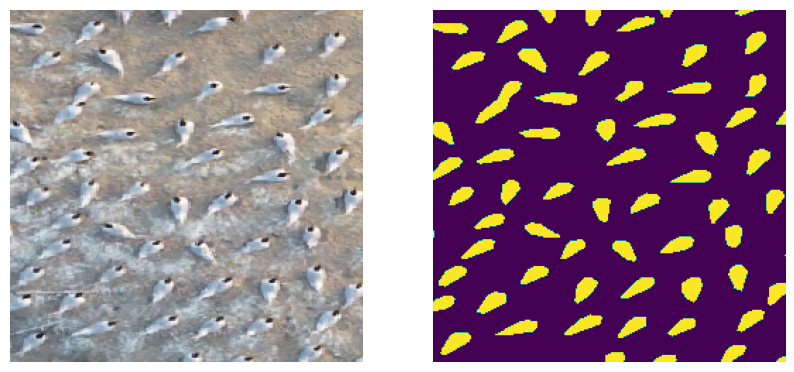

In [19]:
# Check if raster and mask tiles correspond
import random

# Create a figure with two subplots arranged in a 1x2 grid
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# See random tile
tile_numb = random.randint(0, len(raster_tiles)-1)
print(tile_numb)

# Plot the images
axs[0].imshow(raster_tiles[tile_numb].astype(np.uint8))
axs[0].axis('off')  # Turn off axis labels and ticks
axs[1].imshow(mask_tiles[tile_numb].astype(np.uint8))
axs[1].axis('off')

## Write images, masks and annotations to file

In [20]:
# For each tile, write to file and create annotations

# Out paths
out_img_path = "gdrive/My Drive/Stage/Data/Input/Train/Ready/Images/"
out_mask_path = "gdrive/My Drive/Stage/Data/Input/Train/Ready/Masks/"
out_anno_path = "gdrive/My Drive/Stage/Data/Input/Train/Ready/Annotations/"

for i in range(len(raster_tiles)):

  # Output path
  out_img = out_img_path + "img" + str(i+1) + ".png"
  out_mask = out_mask_path + "mask" + str(i+1) + ".png"
  out_ann = out_anno_path + "annotation" + str(i+1) + ".txt"

  # Save images to file
  plt.imsave(out_img, raster_tiles[i].astype(np.uint8), cmap='gray', format='png') # Convert to uint8
  plt.imsave(out_mask, mask_tiles[i].astype(np.uint8), cmap='gray', format='png')

  # Calculate boxes from mask
  mask_tile_img = mask_tiles[i].copy()
  contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Image width and height
  img_colour = Image.open(out_img) # You need to have the colour image somehow (so write image to file first)
  width, height = img_colour.size

  # Class and number of objects
  class_name = "Bird"
  num_objects = len(contours)

  with open(out_ann, 'w') as f:
      # Write annotation to file
      f.write(f'Image filename : "{out_img}"\n')
      f.write(f'Image size (X x Y) : {width} x {height}\n')
      f.write(f'Database : "BirdsBreeding"\n')
      f.write(f'Objects with ground truth : {num_objects} \n\n')

      # Loop over each bird (if any)
      for i, contour in enumerate(contours):
          x, y, w, h = cv2.boundingRect(contour)
          x_min = x
          y_min = y
          x_max = x + w
          y_max = y + h

          f.write(f'# Details for object {i+1} \n')
          f.write(f'Original label for object {i+1} : "{class_name}" \n')
          f.write(f'Bounding box for object {i+1} : (Xmin, Ymin) - (Xmax, Ymax) : ({x_min}, {y_min}) - ({x_max}, {y_max})\n')
          f.write(f'Pixel mask for object {i+1} : "{out_mask}"\n\n')


In [21]:
# If there are many tiles, sometimes wait/check until all are saved even if process is done

count = 0
for idx, file in enumerate(sorted(os.listdir(out_img_path))):

  count = count + 1

print(count)

672
